In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lsst.geom

from lsst.rubintv.production.plotting.nightReportPlotBase import StarTrackerPlot

%matplotlib inline

dayObs = 20230222
mdFilename = os.path.join('/project/rubintv/starTracker/sidecar_metadata', f'dayObs_{dayObs}.json')
metadata = pd.read_json(mdFilename).T
metadata = metadata.sort_index()

In [2]:
def computeAngle(point1, point2):
    # Great Circle Distance
    (long1, lat1) = point1
    (long2, lat2) = point2
    angle = np.arccos(np.sin(lat1) * np.sin(lat2) + 
                      np.cos(lat1) * np.cos(lat2) * 
                      np.cos(long1 - long2))
    return angle

In [3]:
df = metadata[["Calculated Ra", "Calculated Dec", "Calculated Az", "Calculated Alt", 
               "Calculated Ra wide", "Calculated Dec wide", "Calculated Az wide", "Calculated Alt wide"]]
# Discards rows with a nan entry
df = df.dropna()

In [4]:
# get az and alt as floats
az1, alt1 = np.float32(df[["Calculated Az"]].iloc[2])[0], np.float32(df[["Calculated Alt"]].iloc[2])[0]
az2, alt2 = np.float32(df[["Calculated Az wide"]].iloc[2])[0], np.float32(df[["Calculated Alt wide"]].iloc[2])[0]

# Make 2 SpherePoints
spherePoint1 = lsst.geom.SpherePoint(az1*lsst.geom.degrees, alt1*lsst.geom.degrees)
spherePoint2 = lsst.geom.SpherePoint(az2*lsst.geom.degrees, alt2*lsst.geom.degrees)
# Print separation using lsst.geom
print(spherePoint1.separation(spherePoint2).asArcseconds())

# print my own computation for comparison
testPoint1 = np.array([spherePoint1.getRa().asRadians(), spherePoint1.getDec().asRadians()])
testPoint2 = np.array([spherePoint2.getRa().asRadians(), spherePoint2.getDec().asRadians()])
print(computeAngle(testPoint1, testPoint2) * 180 * 3600 / np.pi)

40.03228363470673
40.03228354780086


In [5]:
nRows = len(df)
skySeparations = np.zeros(nRows)
azAltSeparations = np.zeros(nRows)

# Put the df indices into a numpy array for x-axis plotting later
idxs = df.index.values.astype(int)

# Iterate over df rows, make (Ra, Dec) and (Az, Alt) SpherePoints for both Cameras and Compute Angle
for i, (idx, row) in enumerate(df.iterrows()):
    ra, dec, az, alt = row[0], row[1], row[2], row[3]
    raWide, decWide, azWide, altWide = row[4], row[5], row[6], row[7]
    
    skyPointNarrow = lsst.geom.SpherePoint(ra*lsst.geom.degrees, dec*lsst.geom.degrees)
    skyPointWide = lsst.geom.SpherePoint(raWide*lsst.geom.degrees, decWide*lsst.geom.degrees)
    
    azAltPointNarrow = lsst.geom.SpherePoint(az*lsst.geom.degrees, alt*lsst.geom.degrees)
    azAltPointWide = lsst.geom.SpherePoint(azWide*lsst.geom.degrees, altWide*lsst.geom.degrees)
    
    skySeparations[i] = skyPointNarrow.separation(skyPointWide).asArcseconds()
    azAltSeparations[i] = azAltPointNarrow.separation(azAltPointWide).asArcseconds()

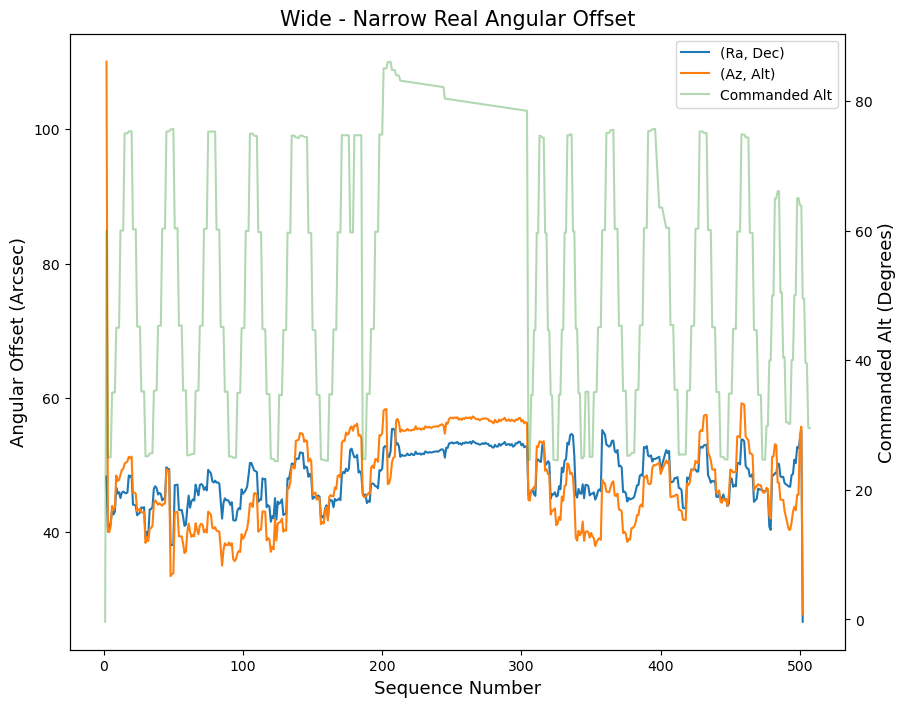

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(idxs, skySeparations, label="(Ra, Dec)")
ax.plot(idxs, azAltSeparations, label="(Az, Alt)")
ax.set_xlabel("Sequence Number", fontsize=13)
ax.set_ylabel("Angular Offset (Arcsec)", fontsize=13)
ax.set_title("Wide - Narrow Real Angular Offset", fontsize=15)
ax2 = ax.twinx()
ax2.plot(metadata["Alt"], label="Commanded Alt", alpha=0.3, color='g')
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc=0)
ax2.set_ylabel("Commanded Alt (Degrees)", fontsize=13)
ax.set_xlabel("Sequence Number", fontsize=13)
plt.show()
fig.savefig("plots/angular_offset.png")